# Multivariate Temporal Dictionary Learning for EEG

This notebook is the work produced by Omar Ahmad and Matias Etcheverry, in the course *Apprentissage pour les séries temporelles* "given by Laurent Oudre and Charles Truong at the MVA".

The goal is to study the notion introduced by the article [Multivariate Temporal Dictionary Learning for EEG](https://arxiv.org/abs/1303.0742). The aim of this article is to generalize the concept of dictionary learning to multivariate signals with shift-invariant atoms.

We proposed to study this algorithm implemented on this [repository](https://github.com/sylvchev/mdla). We focus on the dataset 2a of the Brain Computer Interface IV competition (available [here](https://www.bbci.de/competition/iv/) and should be set in  the `data` folder).

**Table of content:**
1. Dictionary Learning
2. Dictionary learning in a noised setting
3. Dictionary learning with different initializations
4. Classification from activations

## Explore the data

The first step is to explore the data in the dataset. The dataset is made of 18 experiments on 9 participants.

Below is the figure representing the experiement:
1. a cross is shown to the screen
2. a body part is shown to the screen (either right hand, left hand, tongue or feet). This part is called the cue.
3. the participant needs to think about this body parts for a few seconds
4. break of a few seconds
5. repeat from step 2.

An experiment lasts around 45min

<img src="figures/timing_scheme.png" alt="drawing" width="800"/>


The dataset is made of:
* 22 EEG channels sampled at 250Hz
* 3 EOG channels sampled at 250Hz
* 4 classes (right hand, left hand, tongue and feet) 
* 9 participants


**Objective of the challenge**:
The goal of the challenge is to classify the shown cue based on the EEG of a participant.

First, we import all the useful modules.

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.fftpack import fft
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

from mdla.mdla import MultivariateDictLearning, multivariate_sparse_encode
from utils.dictionary import (
    compute_mse,
    compute_reconstruction_rate,
    find_runs,
    gabor_dict_1d,
    load_dictionary,
    reconstruct_signal_from_code,
)
from utils.eeg import (
    SENSOR_TO_EEG_NAMES,
    VALUE_TO_CLASS,
    get_custom_montage,
    load_dataset,
)
from utils.plot import plot_labels, save_eeg_gif

rng_global = np.random.RandomState(0)

# for reloading modules in notebook
%reload_ext autoreload
%autoreload 2

We then define the important variables of the project. The data saved in the dataset doesn't have a proper naming for the EEG channels.

In [47]:
all_eeg_names = list(SENSOR_TO_EEG_NAMES.values())
print(all_eeg_names)

['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16']


We then created the 2D montage of the sensors. This montage is the standard 10-20 montage.

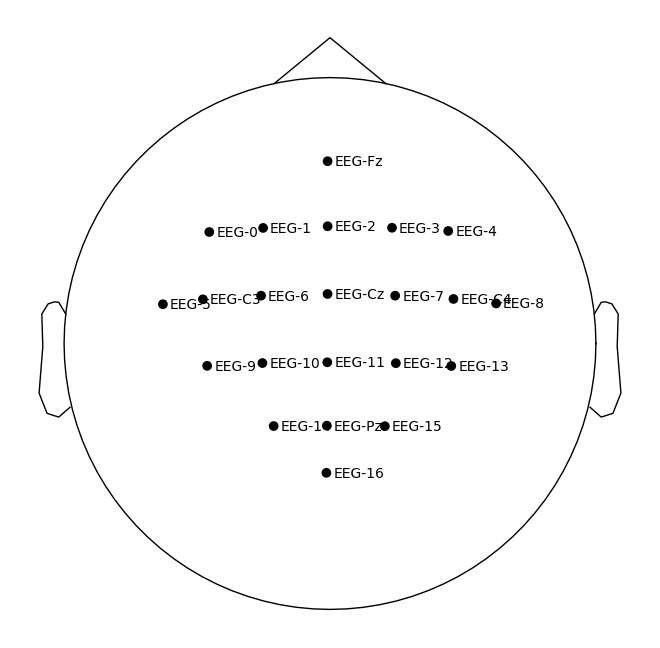

In [5]:
custom_montage = get_custom_montage(SENSOR_TO_EEG_NAMES)
_ = custom_montage.plot()


We load the dataset.

In [6]:
train_raw, train_labels, test_raw, Ts = load_dataset(
    custom_montage=custom_montage, preprocessing=True
)


/home/matias/.pyenv/versions/3.9.8/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/matias/.pyenv/versions/3.9.8/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/matias/.pyenv/versions/3.9.8/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/matias/.pyenv/versions/3.9.8/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
/home/matias/.pyenv/versions/3.9.8/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  

In [7]:
print(f"Number of training participants: {len(train_raw)}")
print(f"Number of testing participants: {len(test_raw)}")
print(f"Sample frequency: {1/Ts}Hz")
print(
    "Number of records: {} (roughly {:.2f}min)".format(
        len(train_raw[0]), len(train_raw[0]) * Ts / 60
    )
)
print(f"Unique labels: {np.unique(train_labels[0])}")
print(f"Number of EEG channels: {train_raw[0].get_data(picks='eeg').shape[0]}")
print(f"Number of EOG channels: {train_raw[0].get_data(picks='eog').shape[0]}")


Number of training participants: 9
Number of testing participants: 9
Sample frequency: 250.0Hz
Number of records: 672528 (roughly 44.84min)
Unique labels: [0 1 2 3 4]
Number of EEG channels: 22
Number of EOG channels: 3


We now plot the EEG channels for the first 2 seconds on the first participant:

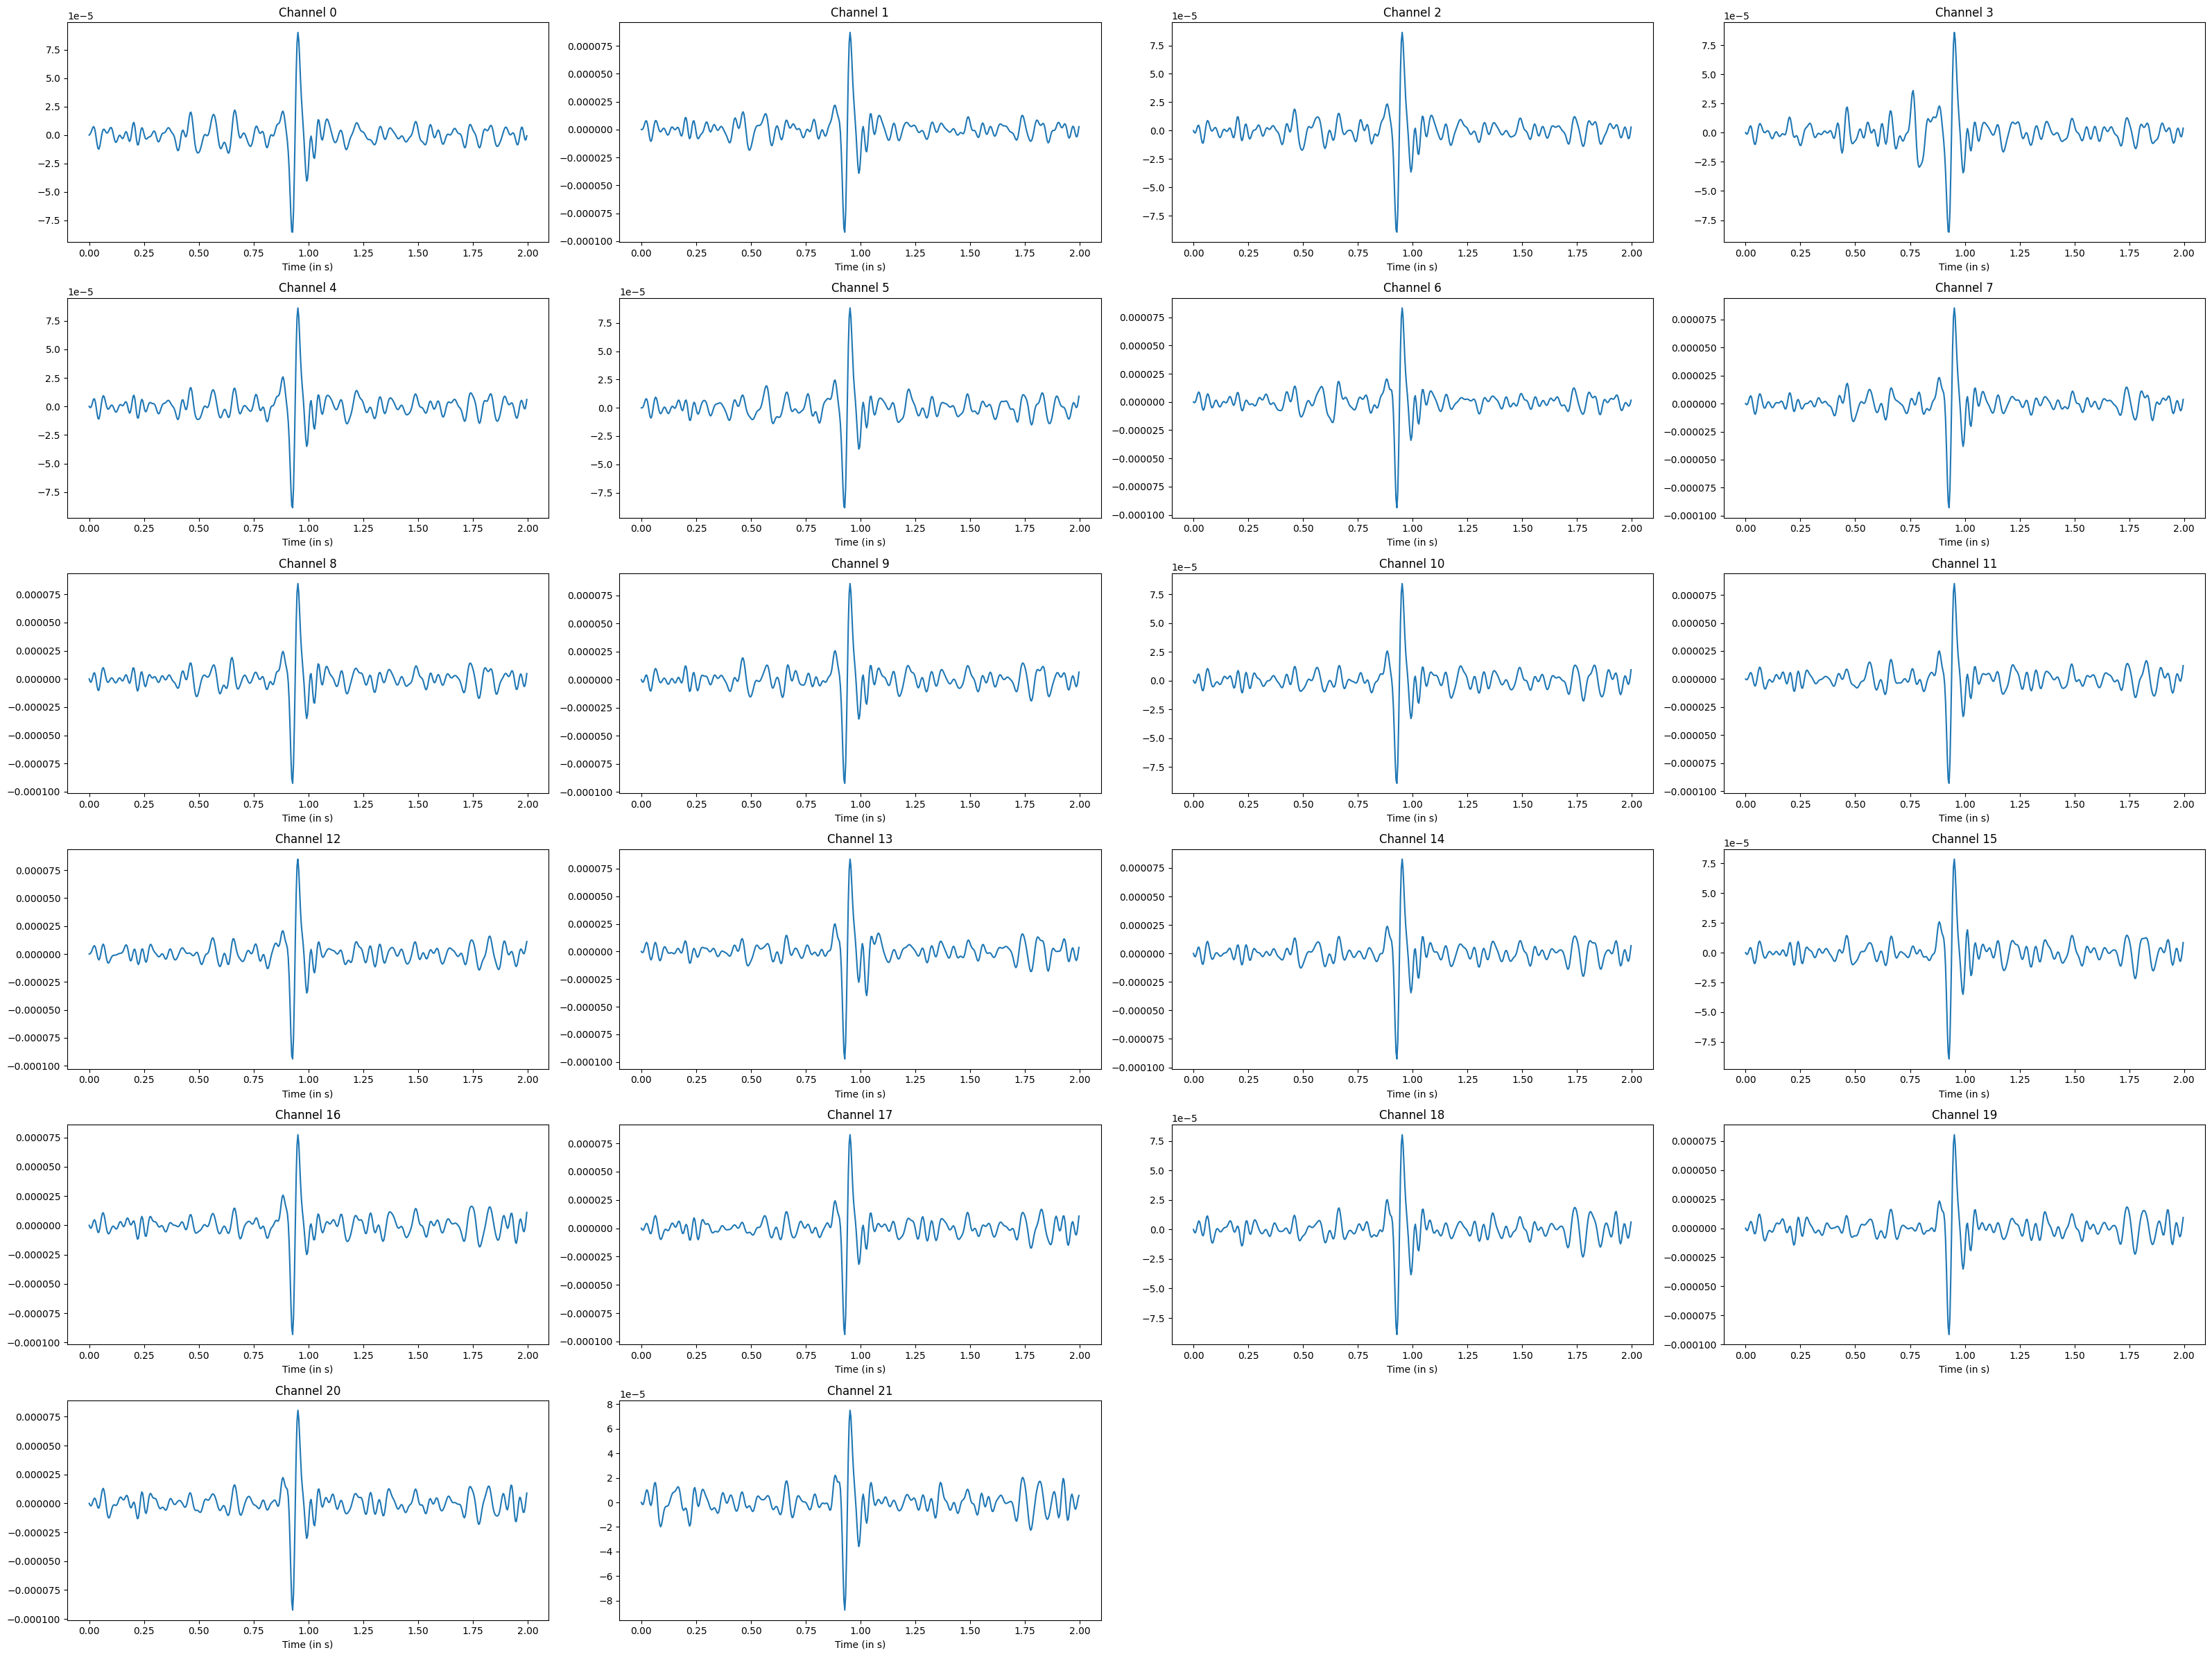

In [8]:
fig, axs = plt.subplots(6, 4, figsize=(8 * 4, 4 * 6))

for row_axes in axs:
    for ax in row_axes:
        ax.axis("off")

for idx, channel in enumerate(train_raw[0].get_data(picks=all_eeg_names)):
    col = idx % 4
    row = idx // 4
    signal = channel[:500]
    times = np.arange(len(signal)) * Ts
    axs[row, col].plot(times, signal)
    axs[row, col].set_xlabel("Time (in s)")
    axs[row, col].set_title(f"Channel {idx}")
    axs[row, col].axis("on")


plt.tight_layout()
plt.savefig("figures/eeg_example.jpg", dpi=300)


We can also see the EEG channels on a topographic map:

In [9]:
%matplotlib notebook

save_eeg_gif(
    original=train_raw[0].get_data(picks=all_eeg_names).T,
    positions=train_raw[0].info,
    start=0,
    length=50,
    timeframe=1,
    fps=10,
    filename="figures/example_eeg.gif",
)


<IPython.core.display.Javascript object>

Creating video from data: 100%|██████████| 50/50 [00:09<00:00,  5.51it/s]


![](figures/example_eeg.gif)

Finally, we can plot the labels of the first experiment:

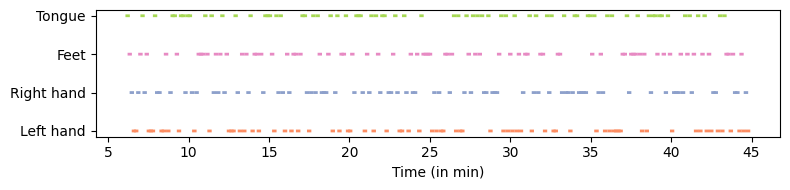

In [11]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
plot_labels(train_labels[0], ax=ax)
plt.tight_layout()
plt.savefig("figures/cues.jpg", dpi=300)


## Dictionary learning

The first experiment we would like to conduct is simply to learn a dictionary from the signal. To do so, we construct a dataset made of the first 500 samples (ie 2s) of each record in the training / testing set

In [12]:
def get_input_from_raw(raw):
    data = raw.get_data(picks=all_eeg_names).T
    return data[:500]


X_train = []
for traw in tqdm(train_raw, desc="Extracting training data"):
    X_train.append(get_input_from_raw(traw))
X_train = np.stack(X_train, axis=0)

X_test = []
for traw in tqdm(test_raw, desc="Extracting testing data"):
    X_test.append(get_input_from_raw(traw))
X_test = np.stack(X_test, axis=0)

print(f"Number of training participants (training records): {len(X_train)}")
print(f"Number of testing participants (testing records): {len(X_test)}")
print(f"Length of a record: {len(X_train[0])} samples (equals {len(X_train[0])*Ts}s)")


Extracting testing data: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s]

Number of training participants (training records): 9
Number of testing participants (testing records): 9
Length of a record: 500 samples (equals 2.0s)


We then introduce the parameters for our dictionary learning:
* we want 8 different kernels
* we want the reconstruction to involve a combination of length at most 40 of those 8 kernels
* the kernels are initialized with specific length.

In [13]:
n_kernels = 8
n_nonzero_coefs = 40
kernel_init_len = [25, 25, 50, 50, 75, 75, 100, 100]


We create a dictionary and fit it to the training set:

In [14]:
print("Fitting... ", end="")
dico = MultivariateDictLearning(
    n_kernels=n_kernels,
    n_nonzero_coefs=n_nonzero_coefs,
    max_iter=200,
    kernel_init_len=kernel_init_len,
    learning_rate=0.7,
).fit(X_train.copy())

print("Done")
print("Predicting on train set... ", end="")

residual, code_train = multivariate_sparse_encode(
    X_train.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
)

print("Done")
print("Predicting on test set... ", end="")

residual, code_test = multivariate_sparse_encode(
    X_test.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
)
print("Done")


Fitting... Done
Predicting on train set... Done
Predicting on test set... Done


In the notebook, the `code` variable represents a sparse encoding of the signal. Basically, it is composed of the necessary information (eg activation and ofset of the kernels) used for reconstructing a whole signal.

We then reconstruct the signal, based only on the dictionary and its sparse encoding:

In [15]:
reconstructions = reconstruct_signal_from_code(code_test, dico, sample_signal=X_test[0])
reconstructions_rate = compute_reconstruction_rate(X_test, reconstructions)

print("Average residual: {:.6f}".format(np.mean(np.linalg.norm(residual, axis=(1, 2)))))
print("Average reconstruction rate: {:.4f}".format(np.mean(reconstructions_rate)))


Average residual: 0.000465
Average reconstruction rate: 0.5059


We plot the kernels of the dictionary. Each plot is a kernel of the dictionary (8 kernels), while each color represents a kernel on a specific channel.

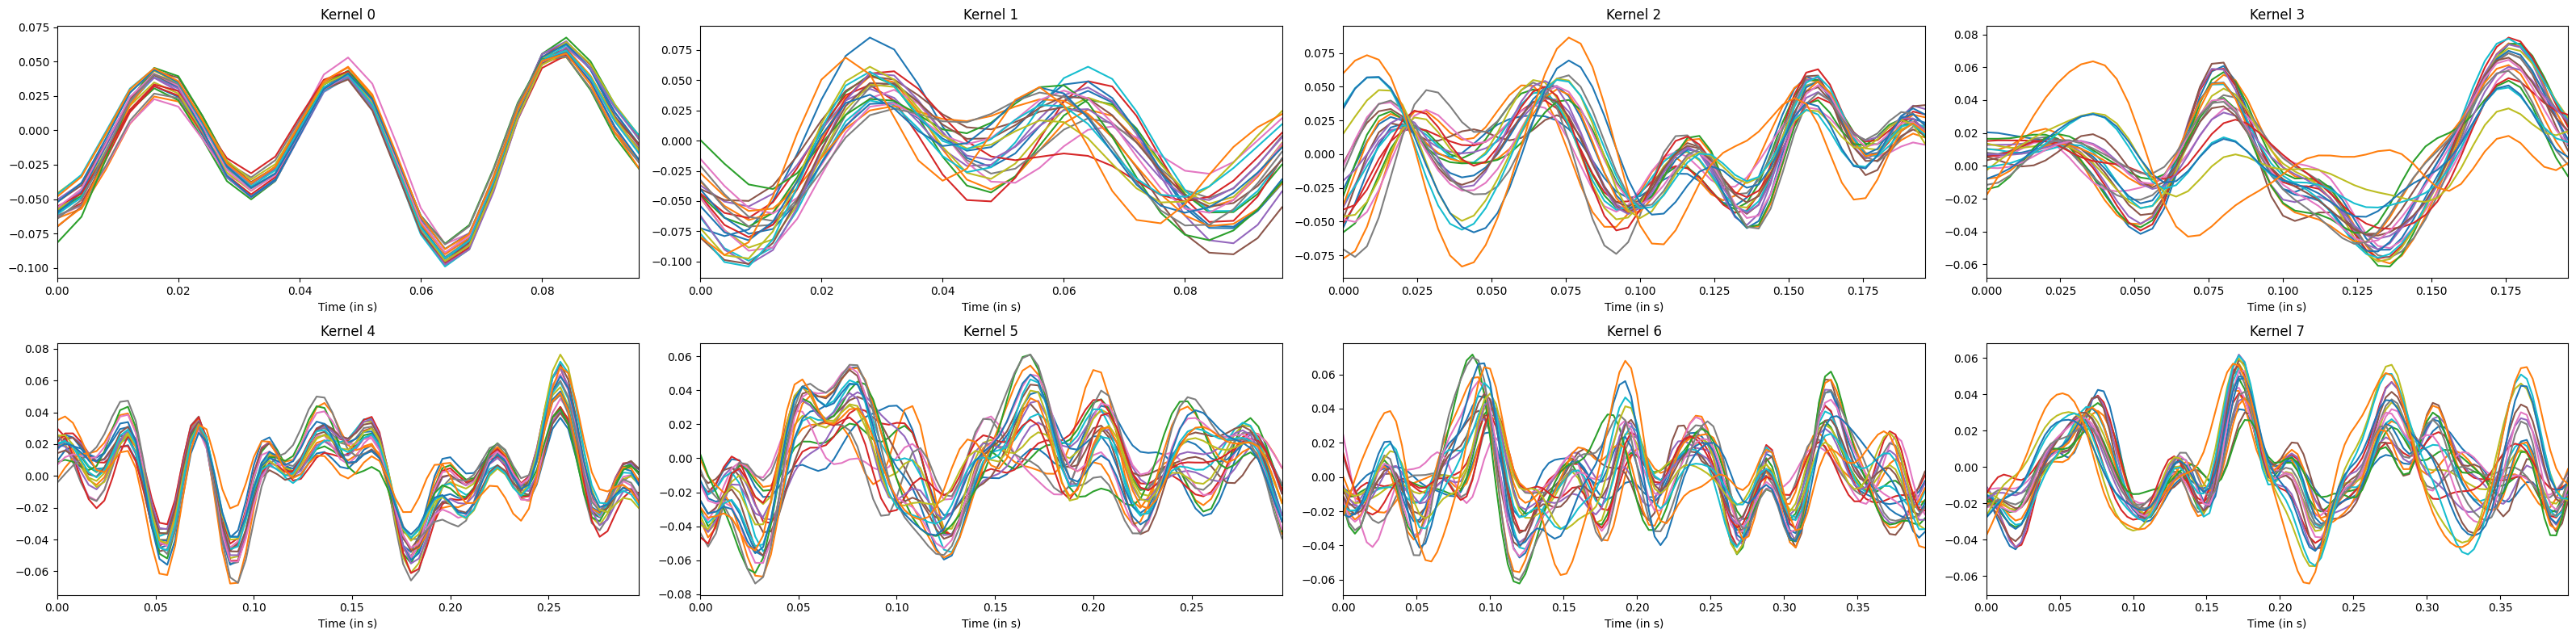

In [16]:
fig, axs = plt.subplots(n_kernels // 4, 4, figsize=(8 * 4, 1 * n_kernels))

for idx_kernels, kernels in enumerate(dico.kernels_):
    col = idx_kernels % 4
    row = idx_kernels // 4
    times = np.arange(len(kernels.T[0])) * Ts
    for idx_channel, kernel in enumerate(kernels.T):
        axs[row, col].plot(times, kernel)
    axs[row, col].set_xlim([0, times[-1]])
    axs[row, col].set_xlabel("Time (in s)")
    axs[row, col].set_title(f"Kernel {idx_kernels}")

plt.tight_layout()
plt.savefig("figures/kernels.jpg", dpi=300)


We notice that the kernels are all differents and encode different kinds of information:
* kernel 4 encodes highly periodic signals with period of roughly 0.1s
* kernel 1 encodes more a Dirac

We can also plot the FFT of the 7th kernel to show a high intra-kernel variance.

> Note: when re-running the learning cell, the found dictionary may change, and thus permuting the kernels.

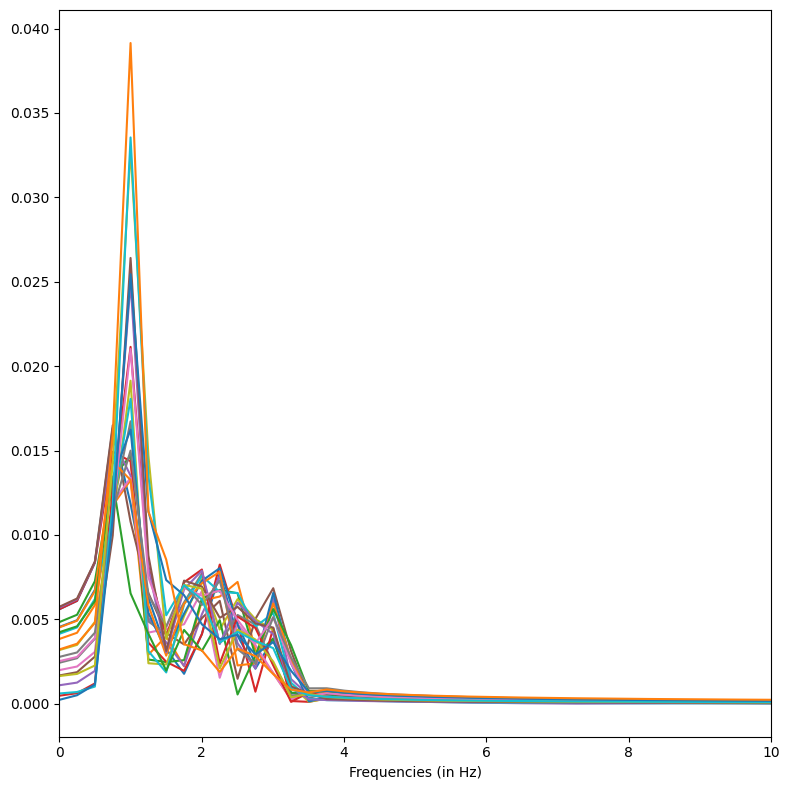

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for idx_channel, kernel in enumerate(dico.kernels_[7].T):
    times = np.arange(len(kernel))
    kernel = np.interp(
        np.linspace(0, len(times), 1000),
        times,
        kernel,
    )
    times = np.linspace(0, times[-1], len(kernel)) * Ts
    N = len(times)
    yf = fft(
        kernel,
    )
    xf = np.linspace(0.0, 1.0 / (2.0 * Ts), N // 2)
    ax.plot(xf, 2.0 / N * np.abs(yf[: N // 2]), label=f"Channel {idx_channel}")
    ax.set_xlim([0, 10])
ax.set_xlabel("Frequencies (in Hz)")
plt.tight_layout()
plt.savefig("figures/fft_channels.jpg", dpi=300)


Finally, we can simply plot the reconstruction. Here, we plot the reconstruction on the 22 channel, in the test set.

Reconstructing test record 4


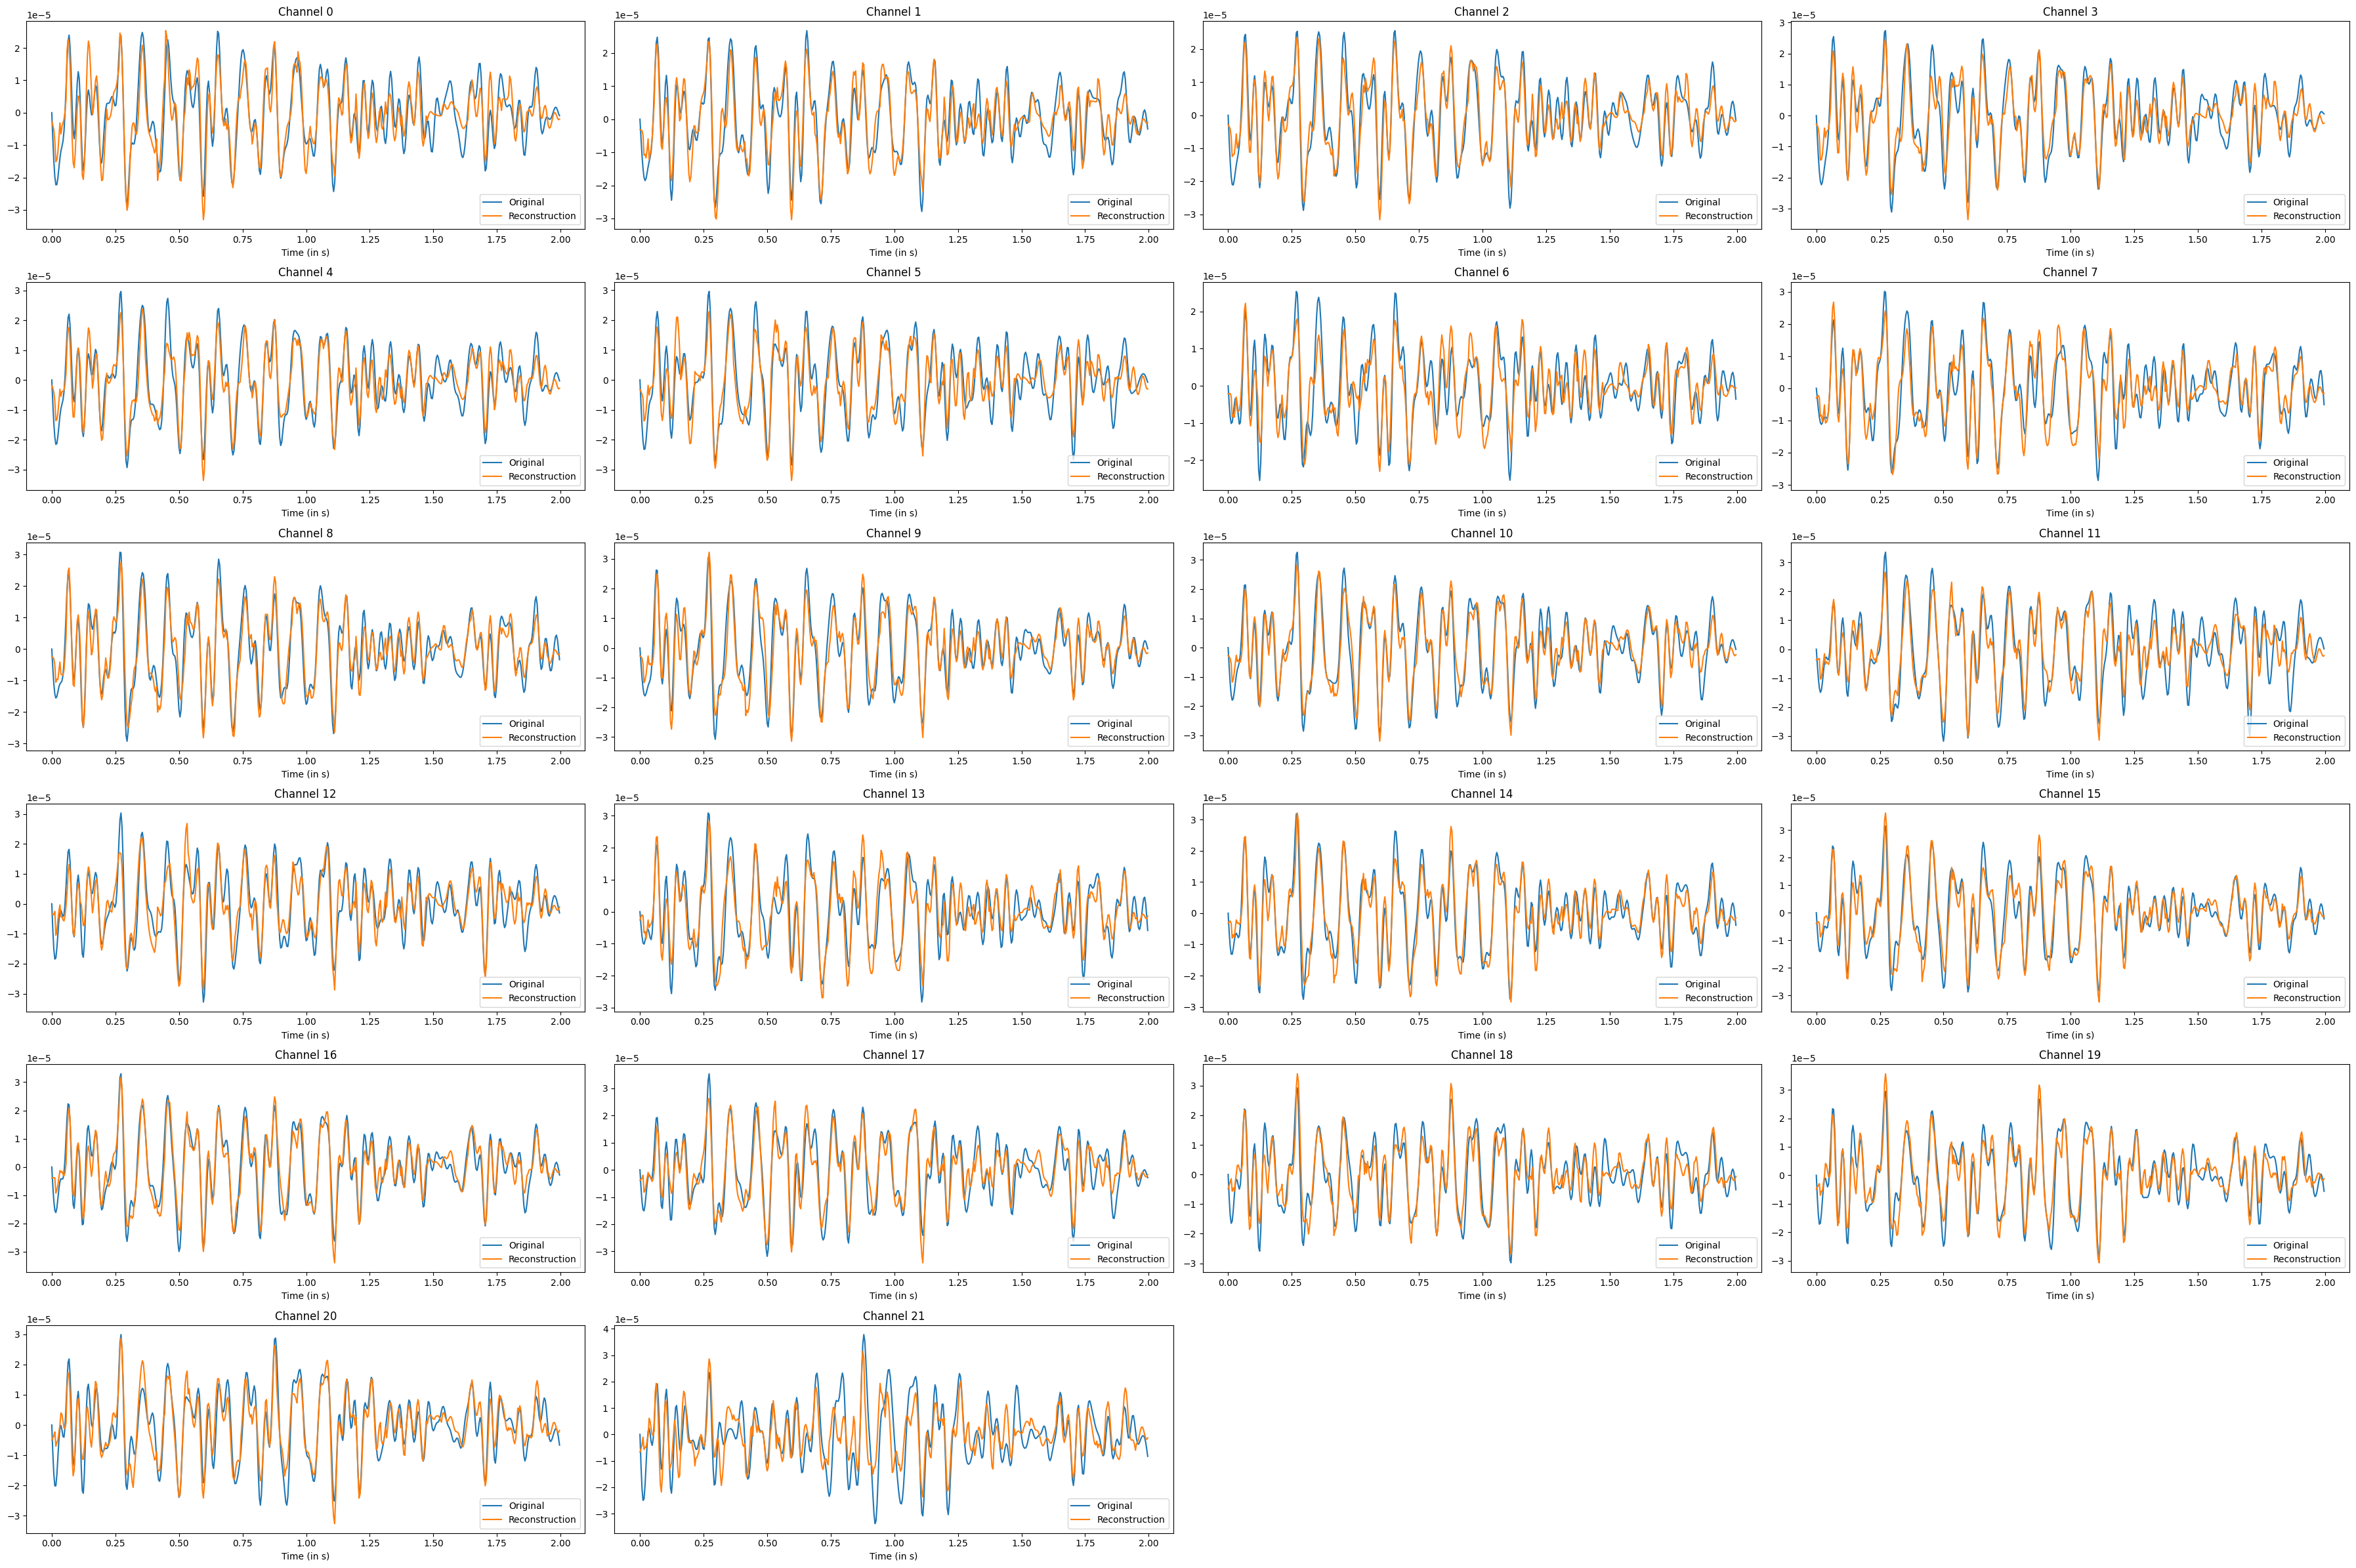

In [18]:
fig, axs = plt.subplots(6, 4, figsize=(18 * 2, 4 * 6))

for ax in axs.flatten():
    ax.axis("off")

idx_reconstruction = np.argmax(reconstructions_rate)
print(f"Reconstructing test record {idx_reconstruction}")
for idx_channel, channel in enumerate(reconstructions[idx_reconstruction].T):
    col = idx_channel % 4
    row = idx_channel // 4
    times = np.arange(len(channel)) * Ts
    axs[row, col].plot(
        times, X_test[idx_reconstruction].T[idx_channel], label="Original"
    )
    axs[row, col].plot(times, channel, label="Reconstruction")
    axs[row, col].set_xlabel("Time (in s)")
    axs[row, col].legend(loc="lower right")
    axs[row, col].set_title(f"Channel {idx_channel}")
    axs[row, col].axis("on")
plt.tight_layout()
plt.savefig("figures/test_reconstructions.jpg", dpi=300)


We can see that the reconstructions are quite good. They are often smoother. 

However, we notice that the dictionary learning has some troubles when the signal is quickly changing its frequency or its amplitude. For instance, in most channels, the amplitude of the original signal is decreasing at $t=1.5s$ and the reconstruction can't handle it well.

Another interesting plot is to display the live signal of the channels on a topographic map:

In [19]:
%matplotlib notebook

save_eeg_gif(
    original=X_test[idx_reconstruction],
    positions=train_raw[0].info,
    reconstruction=reconstructions[idx_reconstruction],
    start=0,
    length=200,
    timeframe=1,
    fps=10,
    filename="figures/test.gif",
    plot_errors=True,
)


<IPython.core.display.Javascript object>

Creating video from data: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


You may have some troubles to visualize the created video, but it is available at `figures/test.gif`.

![Here](figures/test.gif)

## Dictionary learning in a noised setting

Untuitively, the reconstruction rate tells us only how good an reconstruction is able to recover the original signal, but it doesn't really tell how robust it is with noise. We often don't want a perfect reconstruct but rather a denoised reconstruction. 

That is why we decided to conduct a second experiment to see how the dictionary learning behaves in a noised environment. We plot the reconstruction rate and the mean squared error with the original signal (considered unnoisy) and the reconstruction of a noised signal.

We firstly define noise ratios, which will be multiplied by the standard deviation of the signal, before being added.

In [20]:
noise_ratios = np.array(
    [1 / i for i in [1e6, 100, 50, 30, 20, 10]] + [1 / i for i in range(9, 1, -1)]
)


We once again define the hyper parameters of the dictionary learning

In [21]:
n_kernels = 8
n_nonzero_coefs = 40
kernel_init_len = [25, 25, 50, 50, 75, 75, 100, 100]


In [22]:
%matplotlib inline

metrics = [] # contains the training and testing reconstruction rate and MSE
for noise_ratio in tqdm(
    noise_ratios, desc="Learning with different amplitude of noise"
):
    # creating the noised signals
    noise_amplitude = noise_ratio * X_train.std(axis=1)[:, None, :]
    X_train_noised = X_train + noise_amplitude * np.random.randn(*X_train.shape)
    X_test_noised = X_test + noise_amplitude * np.random.randn(*X_test.shape)

    # fitting a dictionary on the noised signals
    dico = MultivariateDictLearning(
        n_kernels=n_kernels,
        n_nonzero_coefs=n_nonzero_coefs,
        max_iter=1000,
        kernel_init_len=kernel_init_len,
        learning_rate=0.9,
    ).fit(X_train_noised.copy())

    residual_train, _ = multivariate_sparse_encode(
        X_train_noised.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
    )
    residual_test, _ = multivariate_sparse_encode(
        X_test_noised.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
    )
    # compute the metrics. The reference is the original signal, considered unnoisy
    metrics.append(
        {
            "noise_ratio": noise_ratio,
            "reconstructions_rate_train": np.mean(
                compute_reconstruction_rate(X_train, X_train_noised + residual_train)
            ),
            "reconstructions_rate_test": np.mean(
                compute_reconstruction_rate(X_test, X_test_noised + residual_test)
            ),
            "mse_train": np.mean(compute_mse(X_train, X_train_noised + residual_train)),
            "mse_test": np.mean(compute_mse(X_test, X_test_noised + residual_test)),
        }
    )

metrics = pd.DataFrame.from_records(metrics)


Learning with different amplitude of noise: 100%|██████████| 14/14 [03:22<00:00, 14.50s/it]


We then plot the reconstruction rate and the mean squared error with respect to the noise ratio.

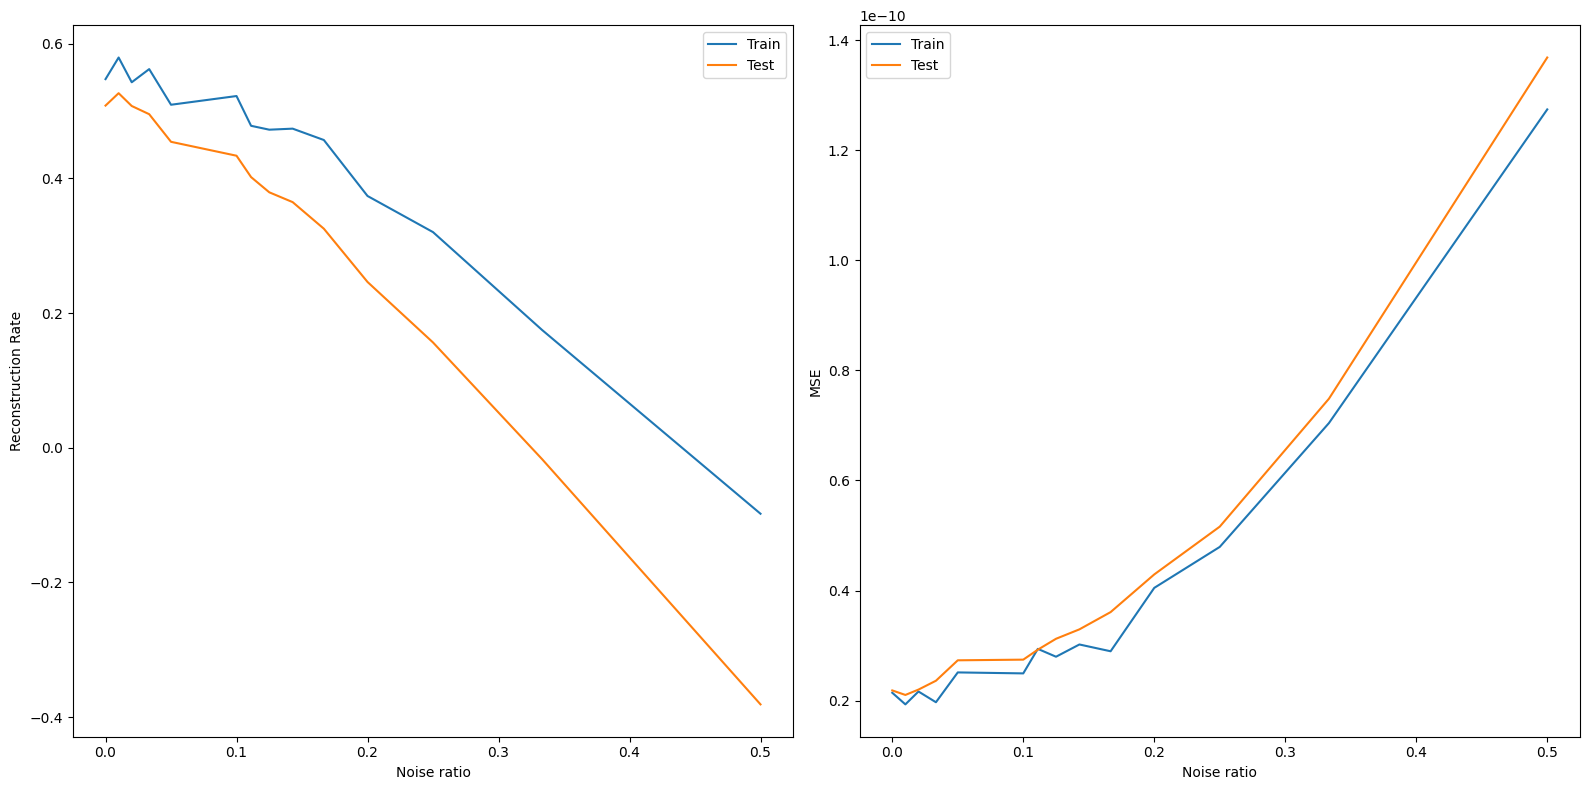

In [24]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].plot(
    metrics["noise_ratio"], metrics["reconstructions_rate_train"], label="Train"
)
axs[0].plot(metrics["noise_ratio"], metrics["reconstructions_rate_test"], label="Test")
axs[0].set_xlabel("Noise ratio")
axs[0].set_ylabel("Reconstruction Rate")
axs[0].legend()

axs[1].plot(metrics["noise_ratio"], metrics["mse_train"], label="Train")
axs[1].plot(metrics["noise_ratio"], metrics["mse_test"], label="Test")
axs[1].set_xlabel("Noise ratio")
axs[1].set_ylabel("MSE")
axs[1].legend()

plt.tight_layout()
plt.savefig("figures/rr_mse_noise.jpg", dpi=300)


With no surprise, the reconstruction rate is decreasing and the MSE is increasing when the noise ratio is increasing. 
The train metrics are always better than the test metrics. When there is no noise, the reconstruction are never perfect.

We also notice that the gap between the train and test reconstruction rates is increasing, while the gap remains almost the same for the MSE. In fact, the reconstruction rate highlights the mean average percentage error, whose behaviour is difficult to interpret when the residual increases.

We also noticed that the dictionary learning was also longer when the noise increases.

> Note: the reconstruction rate can go below 0, when the norm of the residual is larger than the norm of the signal.

## Dictionary Learning with different initializations

We then wanted to check how the learning behaves when we initialize the kernels with different methods. To do so, we implement 3 types of initialization:
* a random initialization based on a Gaussian distribution whose parameters are extracted from the signals
* an initialization from Gabor kernels. Those atoms are frequently used when denoising EEG
* an initialization with part of the signals

First, we create Gabor kernels and plot them.

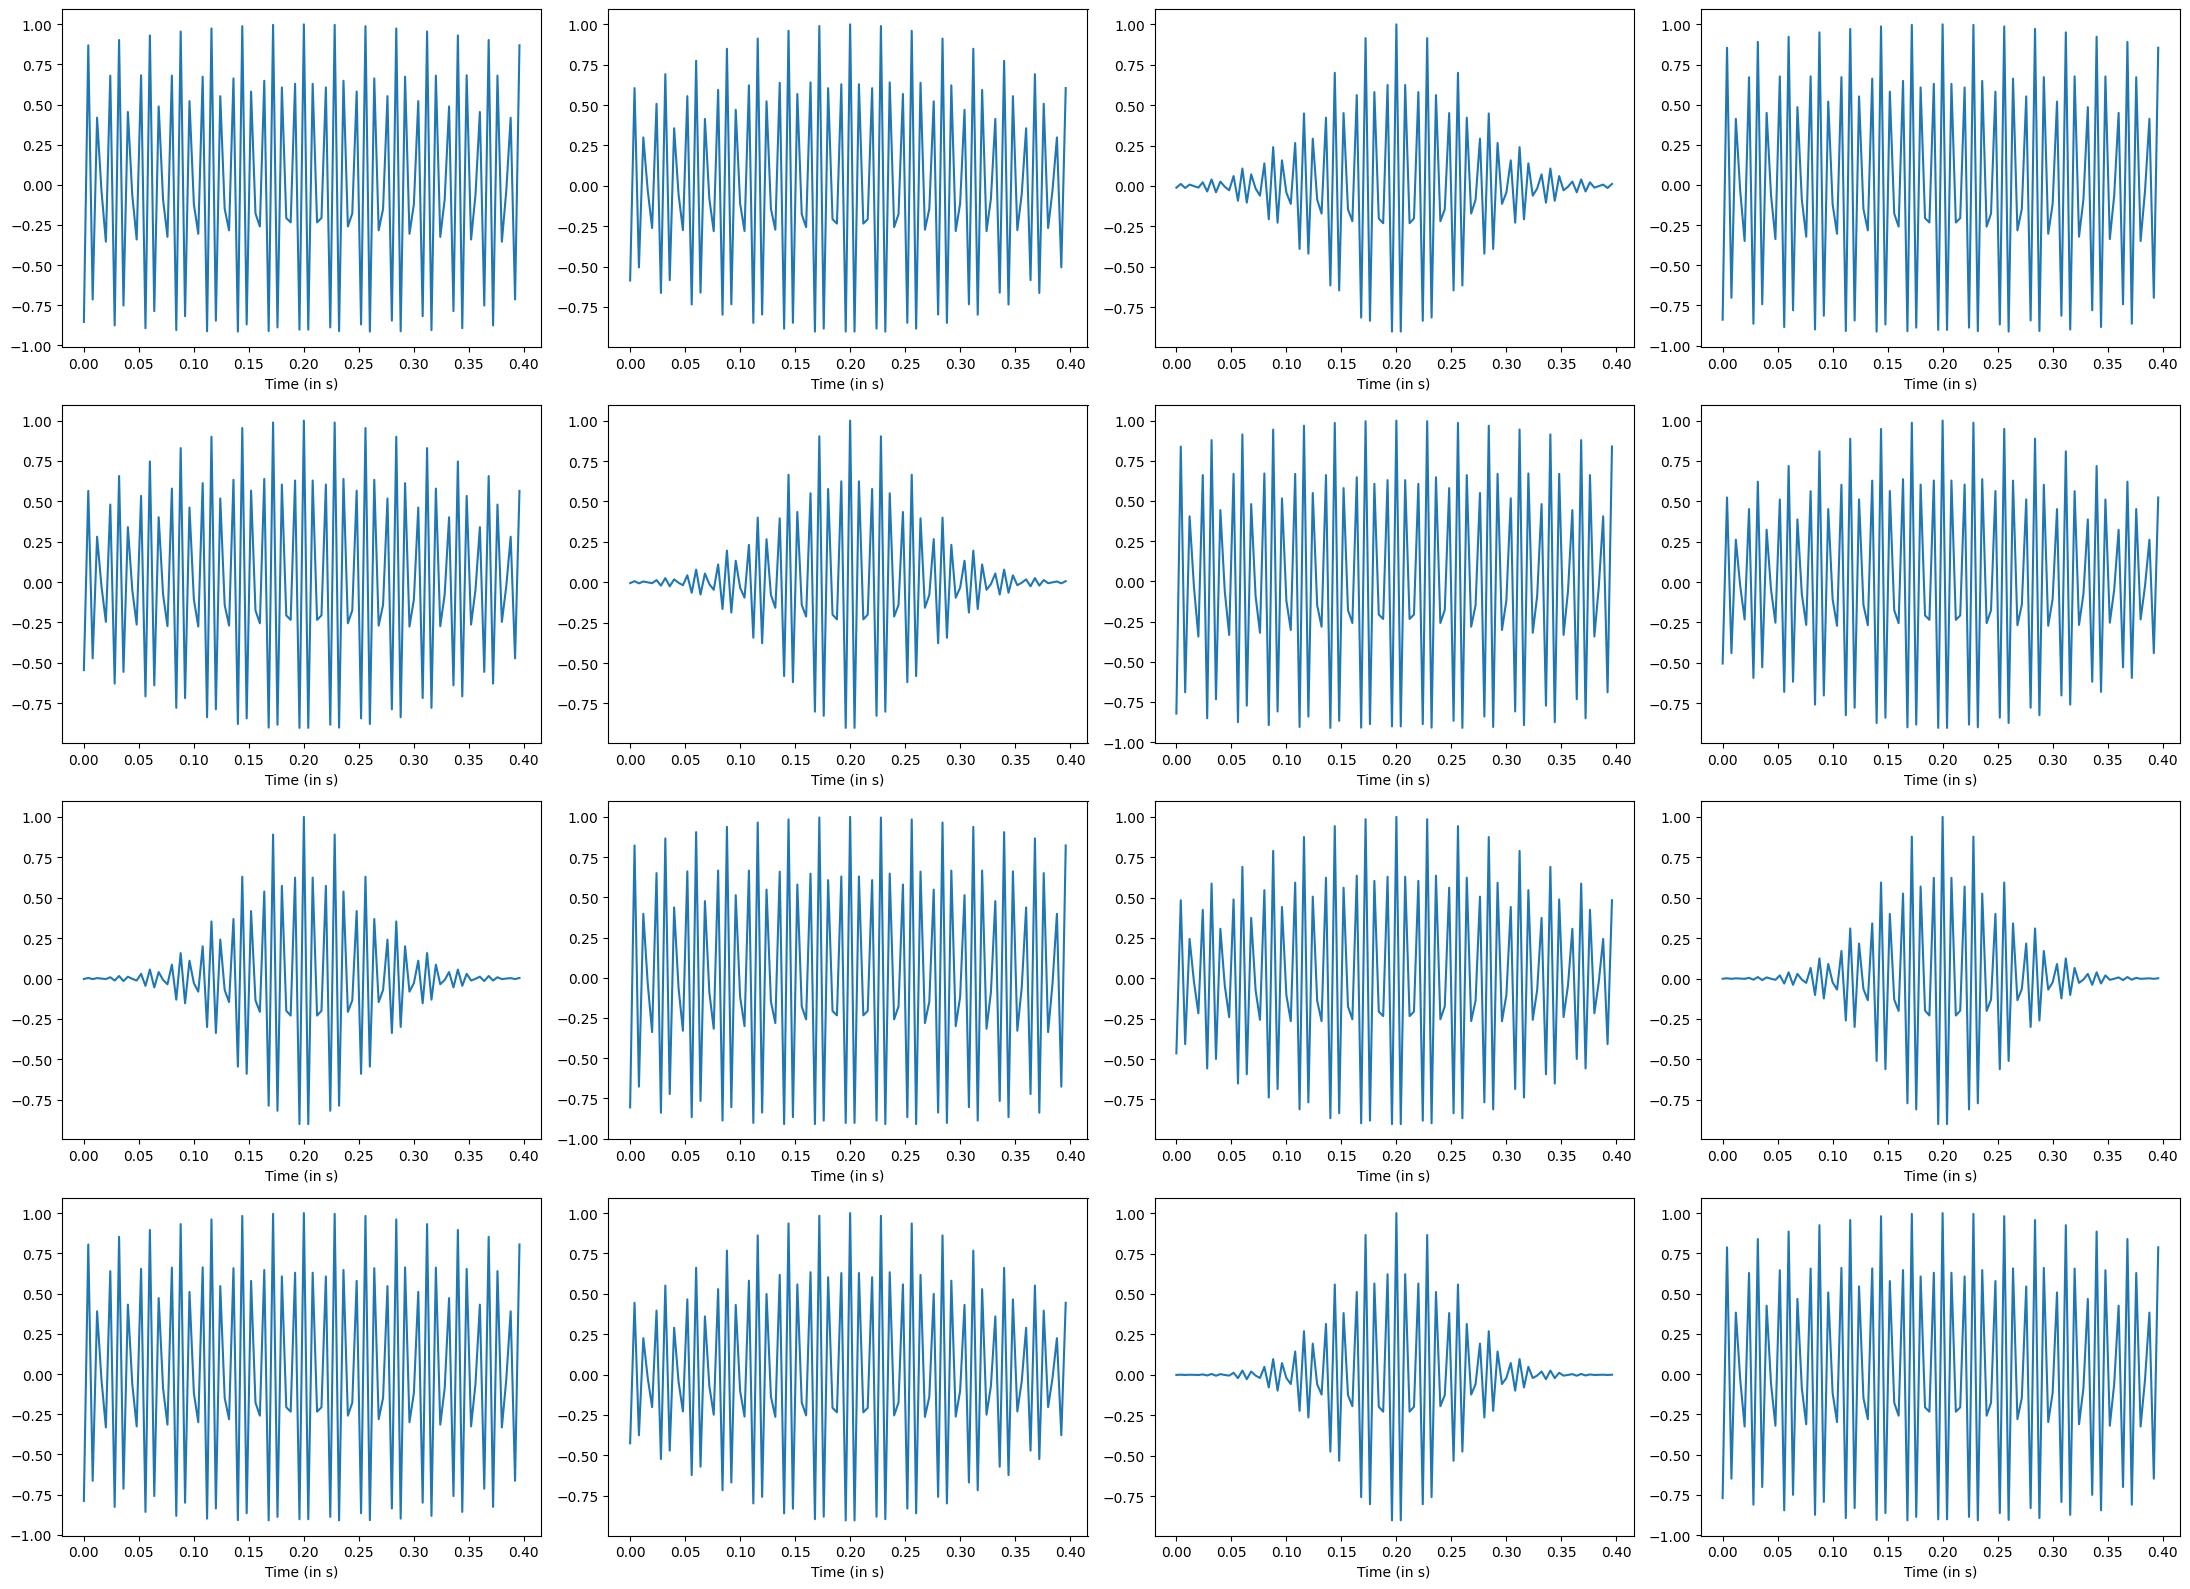

In [25]:
n = 100
kmax = np.pi / 2
fmin = 0.1
fmax = 0.8
alpha = [0.01, 0.02, 0.06]
beta = np.arange(0, np.pi, np.pi / 8)

gabor_kernels = gabor_dict_1d(n, kmax, fmin, fmax, alpha, beta)

# Visualize the first 16 Gabor functions
fig, axs = plt.subplots(4, 4, figsize=(22, 16))
for idx, gab_kernel in enumerate(gabor_kernels.T[:16]):
    col = idx % 4
    row = idx // 4
    times = np.arange(len(gab_kernel)) * Ts
    axs[row, col].plot(times, gab_kernel)
    axs[row, col].set_xlabel("Time (in s)")
plt.tight_layout()
plt.savefig("figures/gabord_dictionary.jpg", dpi=300)


We create the dataset. We keep the first record of the training and testing dataset. We focus on the first 4 seconds and on the 10 first channels.

In [26]:
n_D = np.moveaxis(gabor_kernels.reshape(100, -1, 10), 0, 1)

X_train = train_raw[0].get_data(picks="all").T[None, :1000, :10]
X_test = test_raw[0].get_data(picks="all").T[None, :1000, :10]

noise_amplitude = 0.05 * X_train.std(axis=1)[:, None, :]
X_train_noised = X_train + noise_amplitude * np.random.randn(*X_train.shape)
X_test_noised = X_test + noise_amplitude * np.random.randn(*X_test.shape)


We define the hyper parameters of the learnings:

In [27]:
n_kernels = 5
n_nonzero_coefs = 100
kernel_init_len = 100


We then proceed to dictionary learning with the 3 different initializations.

In [28]:
gaussian_dict = (
    X_train_noised.std() * np.random.randn(*n_D.shape)
    + X_train_noised[:, :100, :].mean(axis=(0, 2))[None, :, None]
)

print("Dictionary learning with initialization from the signal...")
dico_signal = MultivariateDictLearning(
    n_kernels=n_kernels,
    n_nonzero_coefs=n_nonzero_coefs,
    max_iter=1000,
    kernel_init_len=[100] * kernel_init_len,
    learning_rate=0.9,
).fit(X_train_noised.copy())

print("Dictionary learning with initialization from gabor kernels...")
dico_gabor = MultivariateDictLearning(
    n_kernels=n_kernels,
    n_nonzero_coefs=n_nonzero_coefs,
    max_iter=1000,
    dict_init=n_D.tolist(),
    kernel_init_len=kernel_init_len,
    learning_rate=0.9,
).fit(X_train_noised.copy())

print("Dictionary learning with gaussian initialization...")
dico_gaus = MultivariateDictLearning(
    n_kernels=n_kernels,
    n_nonzero_coefs=n_nonzero_coefs,
    max_iter=1000,
    dict_init=gaussian_dict.tolist(),
    kernel_init_len=kernel_init_len,
    learning_rate=0.9,
).fit(X_train_noised.copy())

print("Done")


Dictionary learning with initialization from the signal...
Dictionary learning with initialization from gabor kernels...
Dictionary learning with gaussian initialization...
Done


We reconstruct the signals.

In [29]:
# Computing the sparse encoding of the test dataset
residual, code_signal = multivariate_sparse_encode(
    X_test_noised.copy(), dico_signal, n_nonzero_coefs=n_nonzero_coefs
)
residual, code_gabor = multivariate_sparse_encode(
    X_test_noised.copy(), dico_gabor, n_nonzero_coefs=n_nonzero_coefs
)
residual, code_gaus = multivariate_sparse_encode(
    X_test_noised.copy(), dico_gaus, n_nonzero_coefs=n_nonzero_coefs
)

# Reconstructing the signal from the sparse encoding
reconstructions_signal = reconstruct_signal_from_code(
    code_signal, dico_signal, X_test_noised[0]
)
reconstructions_gabor = reconstruct_signal_from_code(
    code_gabor, dico_gabor, X_test_noised[0]
)
reconstructions_gaus = reconstruct_signal_from_code(
    code_gaus, dico_gaus, X_test_noised[0]
)


We compute the reconstruction rates

In [30]:
print(
    "Reconstruction rate from signal init: {:.6f}".format(
        np.mean(compute_reconstruction_rate(X_test_noised, reconstructions_signal))
    )
)
print(
    "Reconstruction rate from Gabor init: {:.6f}".format(
        np.mean(compute_reconstruction_rate(X_test_noised, reconstructions_gabor))
    )
)
print(
    "Reconstruction rate from random init: {:.6f}".format(
        np.mean(compute_reconstruction_rate(X_test_noised, reconstructions_gaus))
    )
)


Reconstruction rate from signal init: 0.609962
Reconstruction rate from Gabor init: 0.364355
Reconstruction rate from random init: 0.161757


We reconstruction rate is best when initializing  with the signal itself. We finally plot the reconstructions 

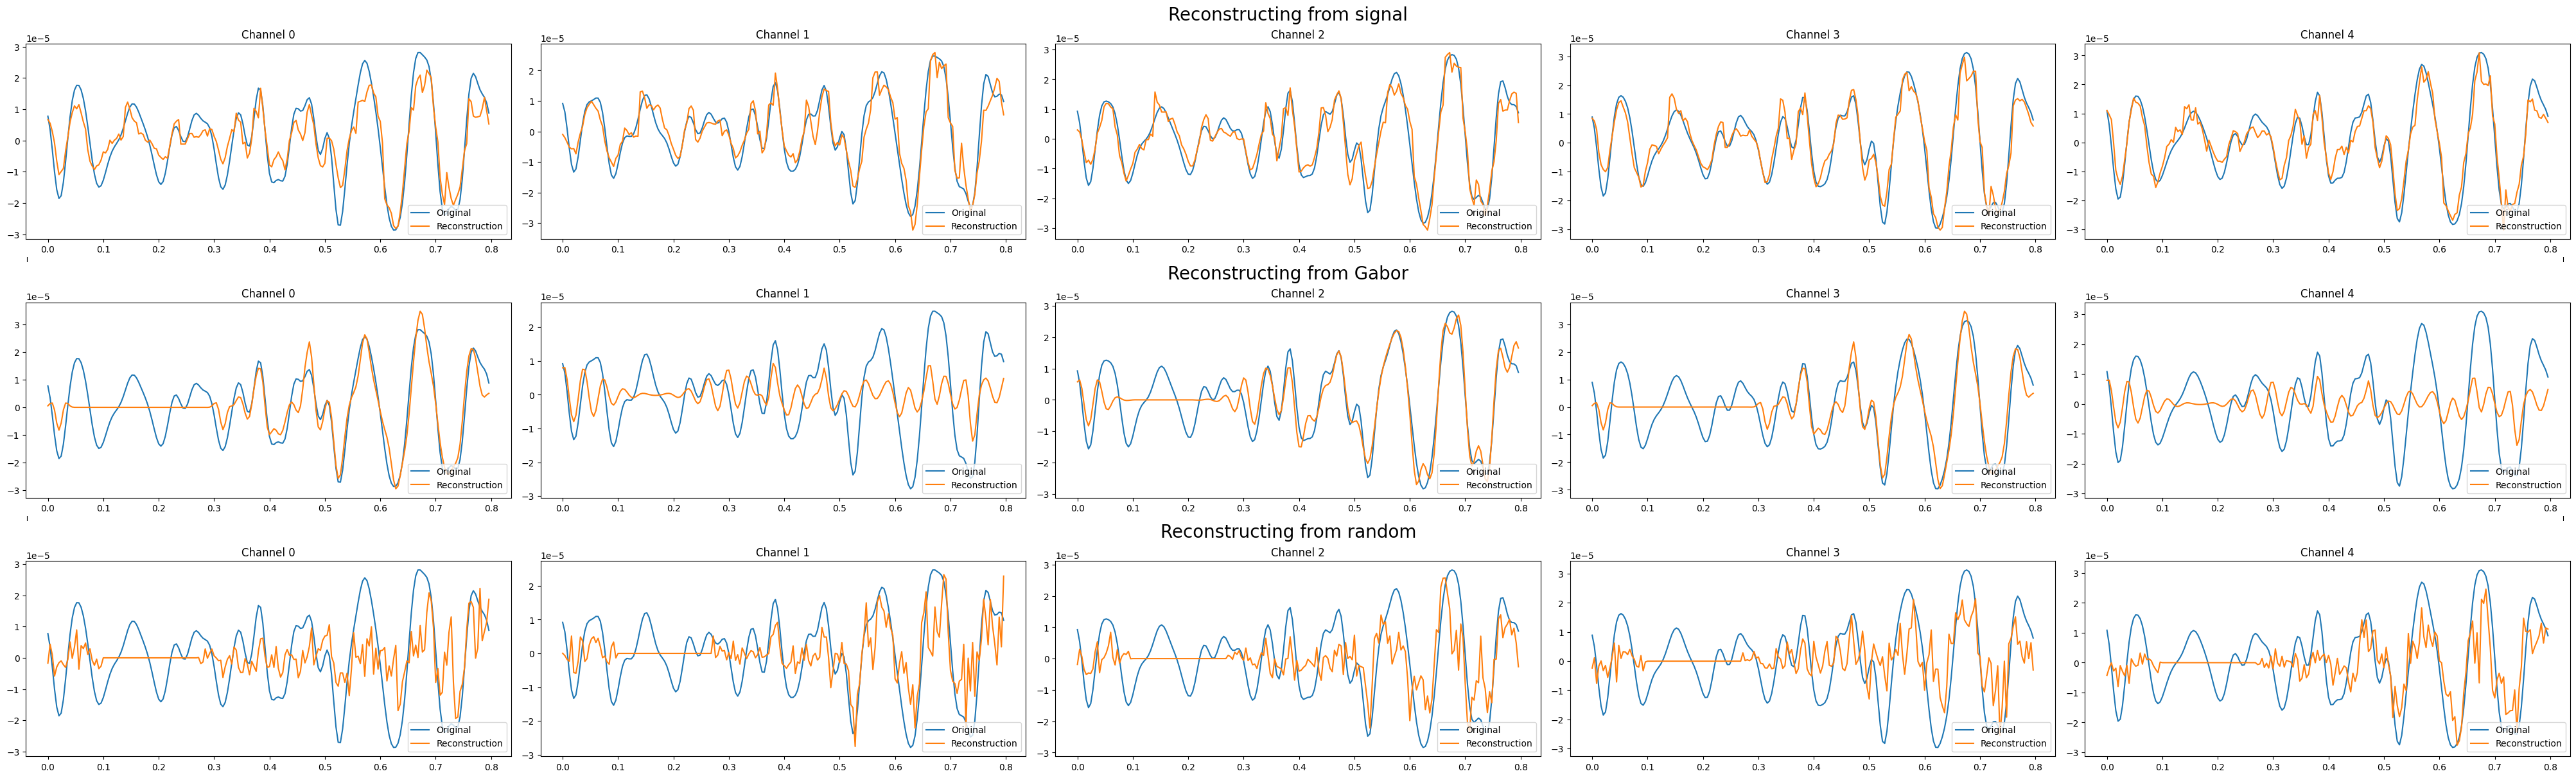

In [31]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(40, 12))
length_signal = 200

subfigs = fig.subfigures(nrows=3, ncols=1)
for row, (reconstruction_name, reconstructions) in enumerate(
    {
        "signal": reconstructions_signal,
        "Gabor": reconstructions_gabor,
        "random": reconstructions_gaus,
    }.items()
):
    subfig = subfigs[row]
    subfig.suptitle(f"Reconstructing from {reconstruction_name}", fontsize=20)

    axs = subfig.subplots(nrows=1, ncols=5)
    for col, (ax, reconstruction) in enumerate(zip(axs, reconstructions[0].T)):
        reconstruction = reconstructions[0].T[col, 100 : 100 + length_signal]
        original = X_test[0, 100 : 100 + length_signal, col]
        times = np.arange(len(reconstruction)) * Ts
        ax.plot(times, original, label="Original")
        ax.plot(times, reconstruction, label="Reconstruction")
        ax.legend(loc="lower right")
        ax.set_title(f"Channel {col}")

plt.savefig("figures/differents_init_reconstructions.jpg", dpi=300)


The reconstruction is always better when initializing with the signal itself.

## Classification from activations

Now our goal is to classify the motor imagery from the activations of the kernels. As they are 4 balanced classes, a dummy classifier would have an accuracy of 25%. We will try to do better, based only on the activations of the kernel. We indeed believe that some kernels may be related to the brain seeing a specific cue. 

### Create the dataset

We only focus on the 2 first participants. Each participants made the same experiment (as explained above).

The goal is to classify the motor imagery. We work in a simplified setting where we know when each cue was shown to the screen. For a cue shown at instant $t$, we extract the 22 EEG from $t+0.6$ to $t+2.6$ (times are expressed in seconds).

In [32]:
def get_input_target_from_raw(raw, labels):
    data = raw.get_data(picks=all_eeg_names).T

    run_values, run_starts, _ = find_runs(labels)
    idx = run_values != 0
    start = run_starts[idx]
    labels = run_values[idx][:-1]

    data = np.array([data[s + 150 : s + 150 + 500] for s in start[:-1]])
    return data, labels


data = []
labels = []
for raw, label in zip(train_raw[:2], train_labels[:2]):
    _data, _label = get_input_target_from_raw(raw, label)
    data.append(_data)
    labels.append(_label)
data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)

Ts = train_raw[0]["EEG-Fz"][1][1]

print("Number of studied participants: 2")
print(f"Number of records: {len(data)}")
assert len(data) == len(
    labels
), "There must be the same number of records in data and in labels."
print(f"Length of records: {len(data[0])} samples (equals {len(data[0])*Ts}s)")
print(f"Samples of labels: {labels[:10]}")


Number of studied participants: 2
Number of records: 574
Length of records: 500 samples (equals 2.0s)
Samples of labels: [4 3 2 1 1 2 3 4 2 3]


We then split the dataset in a 80-20 ratio.

In [33]:
np.random.seed(0)

X_train, X_test, Y_train, Y_test = train_test_split(
    data, labels, train_size=0.8, random_state=0
)


We initialize the hyper-parameters of the multivariate dictionary learning:
* 10 kernels
* 10 possible activations for each record
* All the kernels have a length of 100 samples (0.4s)

In [34]:
n_kernels = 10
n_nonzero_coefs = 10
kernel_init_len = [100] * n_kernels


### dictionary learning

We proceed to the dictionary learning (it may take a while, up to 5min)

In [35]:
print("Fitting... ", end="")
dico = MultivariateDictLearning(
    n_kernels=n_kernels,
    n_nonzero_coefs=n_nonzero_coefs,
    max_iter=2000,
    kernel_init_len=kernel_init_len,
    learning_rate=0.8,
).fit(X_train.copy())

print("Done")
print("Predicting on train set... ", end="")

residual, code_train = multivariate_sparse_encode(
    X_train.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
)

print("Done")
print("Predicting on test set... ", end="")

residual, code_test = multivariate_sparse_encode(
    X_test.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
)
print("Done")


Fitting... Done
Predicting on train set... Done
Predicting on test set... Done


### Computing features

In this case, we are not interested in the residuals, but rather in the reconstruction. The provided framework gives us a list of $\texttt{n\_nonzero\_coefs}$ tuples of the shape (amplitude, offset, kernel), for each record in a dataset. For example, a reconstruction of a record would give us:

| Amplitude | Offset (in sample) | Kernel |
|---|---|---|
| 0.252 | 255 | 1 |
| 0.136 | 309 | 2 |
| 0.127 | 120 | 3 |
| -0.3 | 256 | 3 |

The big problem is to construct lights but meaningfull features from such tuples. To do so, we decided to take the minimum, the maximum and the sum of absolute value of activations for every kernel.
For the above example, we would have:

\begin{align*}
    \texttt{features} = [\underbrace{0.252, 0.252, 0.252}_{\text{features of 1st kernel}}, \underbrace{0.136, 0.136, 0.136}_{\text{features of 2nd kernel}}, \underbrace{0.127, 0.3, 0.2135}_{\text{features of 3rd kernel}}]
\end{align*}

In [36]:
def compute_features(code, n_kernels):
    features = []
    for current_code in code:
        max_activations = []
        for i in range(n_kernels):
            filtered_idx = current_code[:, 2] == i
            if np.sum(filtered_idx) > 0:
                max_activations.extend(
                    [
                        np.sum(np.abs([current_code[filtered_idx, 0]])),
                        np.max(np.abs([current_code[filtered_idx, 0]])),
                        np.min(np.abs([current_code[filtered_idx, 0]])),
                    ]
                )
            else:
                max_activations.extend([0] * 3)
        features.append(max_activations)
    features = np.array(features)
    return features


features_train = compute_features(code_train, n_kernels)
features_test = compute_features(code_test, n_kernels)


### Training a SVC

We then feed our features to a SVC, after scaling the features.

Train accuracy: 64.05%
Test accuracy: 46.09%


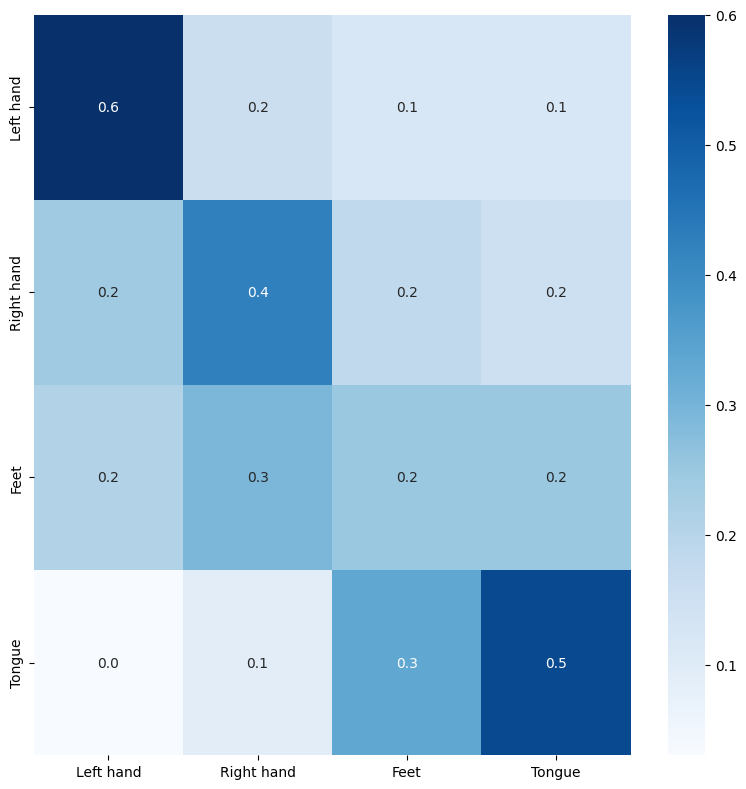

In [37]:
# scaler
scaler = StandardScaler()
scaler.fit(features_train)

# classifier
clf = SVC(C=0.8)
clf.fit(scaler.transform(features_train), Y_train)

# predictions
train_predictions = clf.predict(scaler.transform(features_train))
test_predictions = clf.predict(scaler.transform(features_test))

print(
    "Train accuracy: {:.2f}%".format(accuracy_score(Y_train, train_predictions) * 100)
)
print("Test accuracy: {:.2f}%".format(accuracy_score(Y_test, test_predictions) * 100))

# confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(
    Y_test,
    test_predictions,
    normalize="true",
)
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    ax=ax,
    xticklabels=list(VALUE_TO_CLASS.values()),
    yticklabels=list(VALUE_TO_CLASS.values()),
)
plt.tight_layout()
plt.savefig("figures/cm_classification.jpg", dpi=300)


We now load our best dictionary found

Predicting on train set... Done
Predicting on test set... Done
Train accuracy: 64.05%
Test accuracy: 46.09%


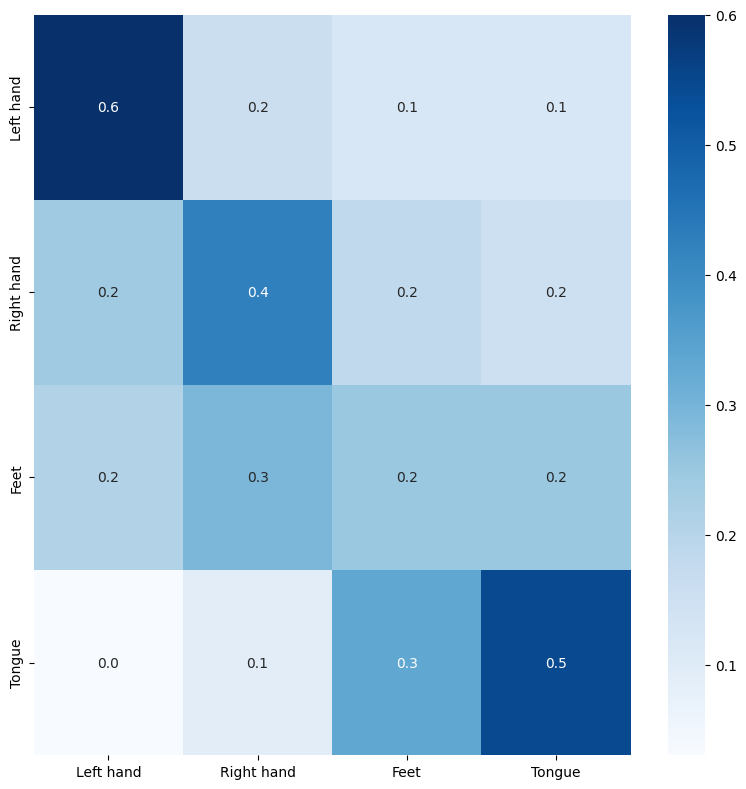

In [38]:
# loading
dico = load_dictionary("best_dico.pkl")

# predictions
print("Predicting on train set... ", end="")
residual, code_train = multivariate_sparse_encode(
    X_train.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
)
print("Done")

print("Predicting on test set... ", end="")
residual, code_test = multivariate_sparse_encode(
    X_test.copy(), dico, n_nonzero_coefs=n_nonzero_coefs
)
print("Done")

# features
features_train = compute_features(code_train, n_kernels)
features_test = compute_features(code_test, n_kernels)

# predictions
train_predictions = clf.predict(scaler.transform(features_train))
test_predictions = clf.predict(scaler.transform(features_test))

print(
    "Train accuracy: {:.2f}%".format(accuracy_score(Y_train, train_predictions) * 100)
)
print("Test accuracy: {:.2f}%".format(accuracy_score(Y_test, test_predictions) * 100))

# confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(
    Y_test,
    test_predictions,
    normalize="true",
)
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    ax=ax,
    xticklabels=list(VALUE_TO_CLASS.values()),
    yticklabels=list(VALUE_TO_CLASS.values()),
)
plt.tight_layout()


we notice that the classification is rather good. Moreover, there is a small confusion between the right and left hand. This is probably due to the participant confusion and/or how the brain works. 

We decided to merge the `Right hand` and `Left hand` labels, to check the confusion matrix.

Test accuracy: 56.52%


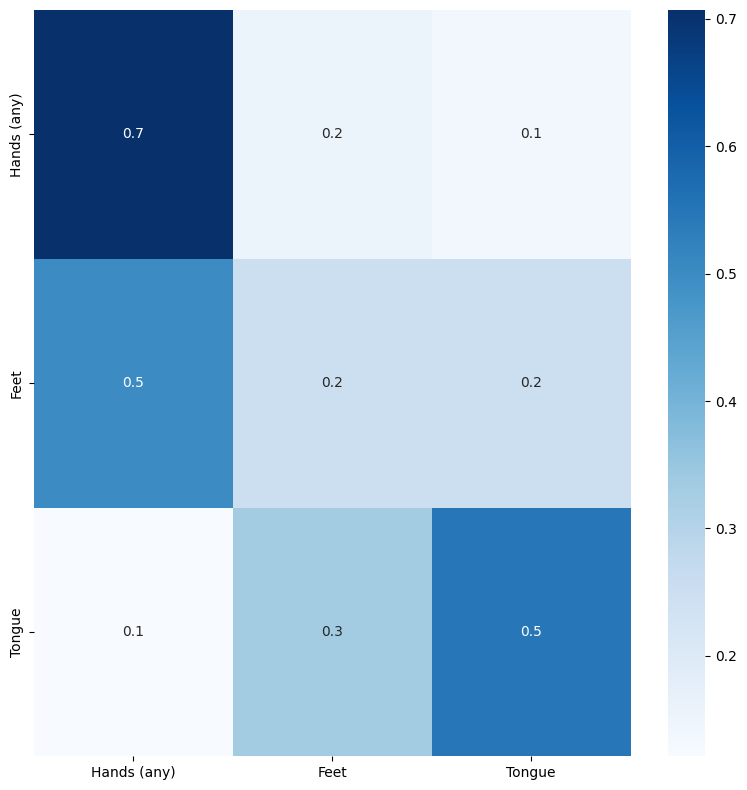

In [39]:
idx_test = np.isin(Y_test, [1, 2])
merged_y_test = Y_test.copy()
merged_y_test[idx_test] = 2
merged_y_test -= 1

idx_pred = np.isin(test_predictions, [1, 2])
merged_test_predictions = test_predictions.copy()
merged_test_predictions[idx_pred] = 2
merged_test_predictions -= 1

print(
    "Test accuracy: {:.2f}%".format(
        accuracy_score(merged_y_test, merged_test_predictions) * 100
    )
)

# confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(
    merged_y_test,
    merged_test_predictions,
    normalize="true",
)
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    ax=ax,
    xticklabels=["Hands (any)", "Feet", "Tongue"],
    yticklabels=["Hands (any)", "Feet", "Tongue"],
)
plt.tight_layout()
# plt.savefig("figures/cm_classification_merged.jpg", dpi=300)


The results is indeed better.

Finally, we want to check if the classification is poor when the reconstruction is poor.

In [40]:
reconstructions = reconstruct_signal_from_code(code_test, dico, sample_signal=X_test[0])
reconstructions_rate = compute_reconstruction_rate(X_test, reconstructions)


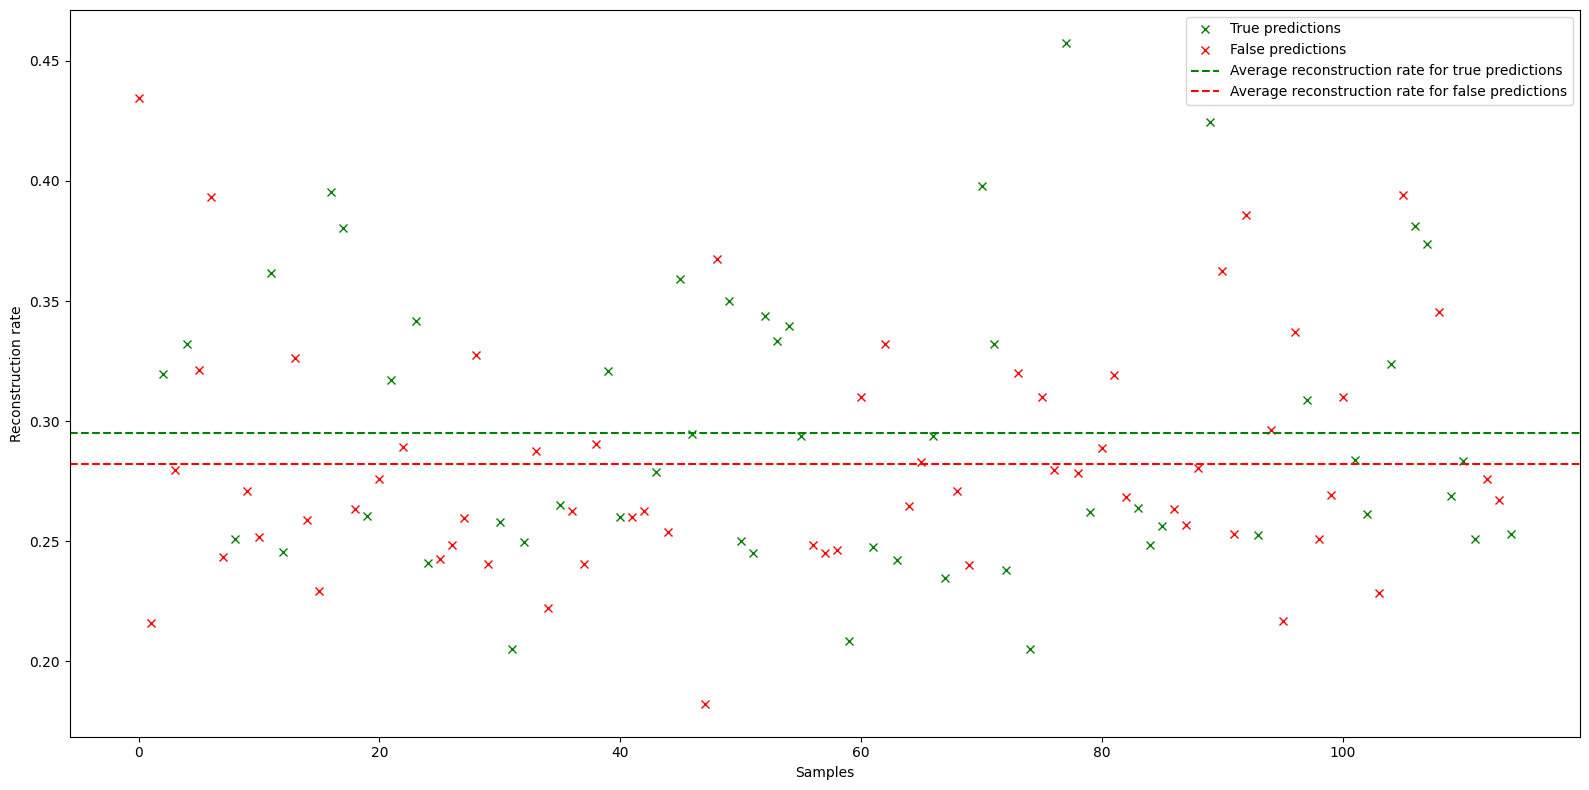

In [41]:
true_predictions_idx = test_predictions == Y_test
x = np.arange(len(Y_test))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    x[true_predictions_idx],
    reconstructions_rate[true_predictions_idx],
    color="green",
    marker="x",
    linestyle="None",
    label="True predictions",
)
ax.plot(
    x[~true_predictions_idx],
    reconstructions_rate[~true_predictions_idx],
    color="red",
    marker="x",
    linestyle="None",
    label="False predictions",
)
ax.axhline(
    np.mean(reconstructions_rate[true_predictions_idx]),
    xmin=0,
    xmax=len(Y_test),
    color="green",
    linestyle="--",
    label="Average reconstruction rate for true predictions",
)
ax.axhline(
    np.mean(reconstructions_rate[~true_predictions_idx]),
    xmin=0,
    xmax=len(Y_test),
    color="red",
    linestyle="--",
    label="Average reconstruction rate for false predictions",
)
ax.set_xlabel("Samples")
ax.set_ylabel("Reconstruction rate")
ax.legend()
plt.tight_layout()
# plt.savefig("figures/reconstruction_rate_vs_errors.jpg", dpi=300)


We finally proceed to a a student test to check if the true and false predictions have the same reconstruction rate.

In [ ]:
test = ttest_ind(
    reconstructions_rate[true_predictions_idx],
    reconstructions_rate[~true_predictions_idx],
    equal_var=False,
)
print("p-value: {:.4f}".format(test.pvalue))
print(
    "We can reject the null hypothesis (ie the reconstruction rate is probably different from true predictions to false predictions)"
)


p-value: 0.0362
We can reject the null hypothesis (ie the reconstruction rate is probably different from true predictions to false predictions)


The difference of classification are correlated to the reconstruction rate. Our intepretation is that reconstructing too well a signal, leads to reconstructing the noise too. The classification algorithm cannot produce good results when there are too much noise. We should probably select less kernel for the reconstruction to improve the classification results. 